# CNN LAB - part B
MobileNetV2 is chosen because it is a powerful yet relatively small model.\
Note that current lab is not aiming at defining optimal model. Focus is rather on roughly exploring some basic concepts using very limited hardvare resources (CPU or GoogleColab limited GPU).

In [ ]:
# Colab specific
# !pip install scikeras[tensorflow]

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from scikeras.wrappers import KerasClassifier
import seaborn as sns

### Help functions

In [ ]:
def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies, test_loss, test_accuracy):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(f'Loss (test loss = {test_loss:.4f})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title(f'Accuracy (test accuracy = {test_accuracy:.4f})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.legend()
    plt.show()


def display_confusion_matrix(y_pred, y_test, labels_list):
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    # Confusion Matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_list, yticklabels=labels_list)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def display_missclassified(y_test, y_pred, labels_list):
  y_test_classes = np.argmax(y_test, axis = 1)
  y_pred_classes = np.argmax(y_pred, axis = 1)
  idx_miss = np.where(y_pred_classes != y_test_classes)[0][:10]

  plt.figure(figsize=(12, 6))

  for i, index in enumerate(idx_miss, 1):
    plt.subplot(2, 5, i)
    plt.imshow(X_test[index])
    plt.title(f'True: {labels_list[y_test_classes[index]]}\nPredicted: {labels_list[y_pred_classes[index]]}')
    plt.axis('off')
  plt.show()

# Data

In [ ]:
# Colab specific
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

Images are saved in separate folders for each flower type

In [ ]:
# list of labels
labels_list = ['sunflower', 'tulip', 'daisy', 'rose', 'dandelion']

# directories where data is saved
dir_list = ['./data/sunflower/', './data/tulip/', './data/daisy/', './data/rose/', './data/dandelion/']

# # google drive folders for Colab experiments
# dir_list = ['/content/drive/MyDrive/Colab Notebooks/lab_CNN/data/sunflower',
#             '/content/drive/MyDrive/Colab Notebooks/lab_CNN/data/tulip',
#             '/content/drive/MyDrive/Colab Notebooks/lab_CNN/data/daisy',
#             '/content/drive/MyDrive/Colab Notebooks/lab_CNN/data/rose',
#             '/content/drive/MyDrive/Colab Notebooks/lab_CNN/data/dandelion']

Create list X of images as arrays and list y with labels (0-4, with index corresponding to labels_list)

In [ ]:
X = []
y = []

for dir in dir_list:
    for filename in os.listdir(dir):
        path = os.path.join(dir, filename)
        img = Image.open(path).resize((128, 128)) # read in image and resize
        img_array = tf.keras.utils.img_to_array(img) # trasform into array
        X.append(img_array)
        y.append(dir_list.index(dir))

X: make array and normalize all 3 channels\
y: make array and apply one-hot encoding into 5 categories

In [ ]:
X_array = np.array(X) / 255.0
# alternatively X_array = tf.keras.applications.mobilenet.preprocess_input(X) could have been used

y_array = np.array(y)
y_array = to_categorical(y_array, len(labels_list))

X_array.shape, y_array.shape

((4317, 128, 128, 3), (4317, 5))

Split data into train, val and test (60:20:20)

In [ ]:
X_trainval, X_test, y_trainval, y_test =train_test_split(X_array, y_array, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val =train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((2589, 128, 128, 3),
 (864, 128, 128, 3),
 (864, 128, 128, 3),
 (2589, 5),
 (864, 5),
 (864, 5))

# POC - Feature extraction followed by finetuning

## Step 1: Understand MobileNetV2 model

In [ ]:
base_model_full = MobileNetV2(weights='imagenet', include_top=True, input_shape=(128, 128, 3))

In [ ]:
len(base_model_full.layers)

156

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [ ]:
len(base_model.layers)

154

Model consists of 16 blocks where for example last block is 8 layers (144-151) followed by addtional 3 layers (152-154)

Classification head is last 2 layers (155-156):\
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D\
<keras.src.layers.core.dense.Dense]\



## Step 2: Feature extraction - create model from MobileNetV2 with new classifier

In [ ]:
def create_feature_extraction_model():
    # read in MobileNetV2 model without the dense classification layers and freeze
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False

    # add classification layer
    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model_fe1 = create_feature_extraction_model()

In [ ]:
model_fe1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 64)                1310784   
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 3569093 (13.62 MB)
Trainable params: 1311109 (5.00 MB)
Non-trainable params: 2257984 (8.61 MB)
__________________

## Step 2: Train and evaluate model

27/27 - 1s - loss: 0.6084 - accuracy: 0.8692 - 558ms/epoch - 21ms/step


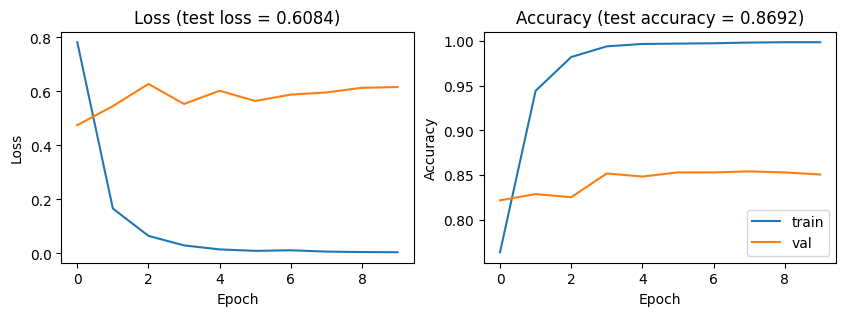

In [ ]:
history = model_fe1.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_fe1.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

Resulting classification has much better accuracy than base models trained in part A of the lab (~50%). It converges fast and trains fast (10 epochs < 1 min). However, the model seem somewhat overfitting and validation loss and accuracy do not improve with training epochs.

27/27 [==============================] - 1s 16ms/step


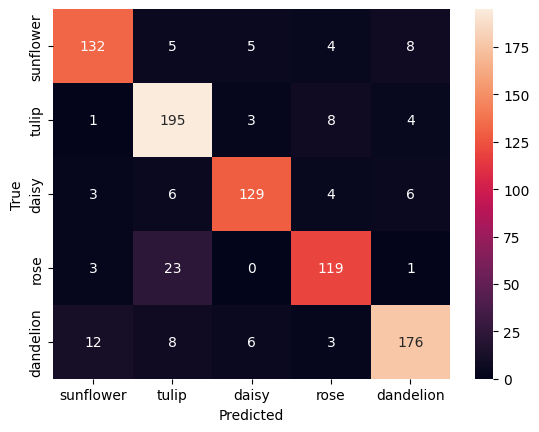

In [ ]:
y_pred = model_fe1.predict(X_test)
display_confusion_matrix(y_pred, y_test, labels_list)

Roses seem to be often confused with tulips. Otherwise miss-classification is fairly even between the different flower types.

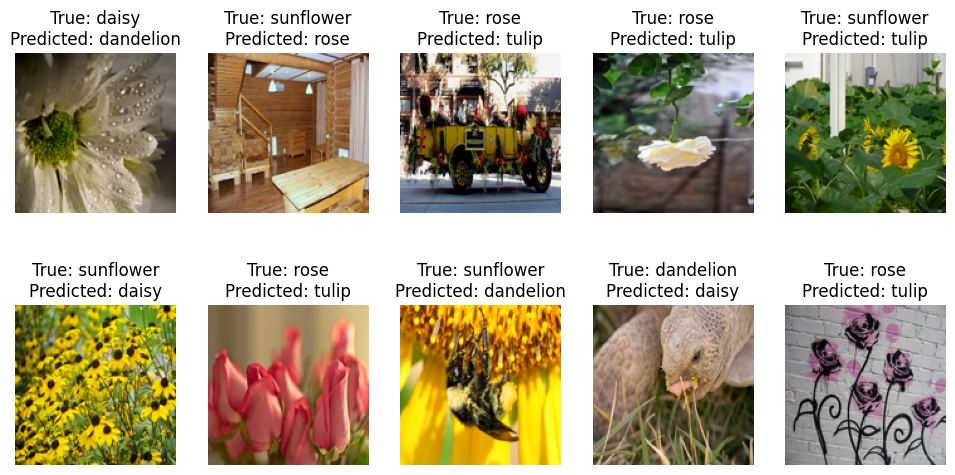

In [ ]:
display_missclassified(y_test, y_pred, labels_list)

Images of missclassified samples show that sample data is not perfect. It is also clear why roses can be missclassifed for tulips.

## Step 3 - finetuning  - create model from MobileNetV2 with same classifier as in step 2

In [ ]:
def create_finetuning_model(first_tunning_layer):
    # read in MobileNetV2 model without the dense classification layers and freeze
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # fine-tune from this layer onwards
    fine_tune_at = first_tunning_layer

    # freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # add classification layer
    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile model with smal learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy']) #low learning rate is chosed for fine tuning

    return model

## Step 3a - finetuning of last block with same classifier

In [ ]:
model_ft1 = create_finetuning_model(144)

In [ ]:
model_ft1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1310784   
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 3569093 (13.62 MB)
Trainable params: 2043589 (7.80 MB)
Non-trainable params: 1525504 (5.82 MB)
________________

27/27 - 1s - loss: 0.5337 - accuracy: 0.8229 - 585ms/epoch - 22ms/step


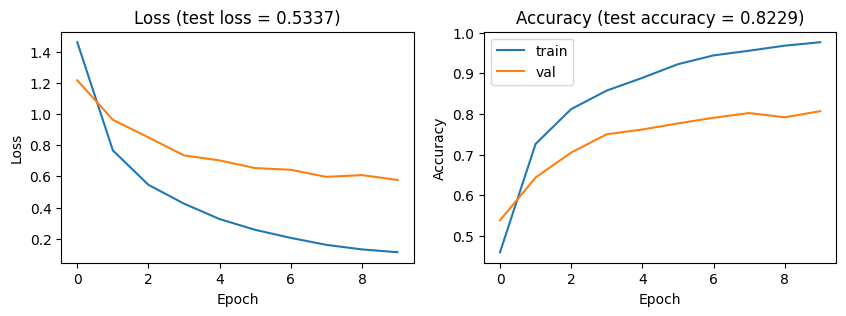

In [ ]:
history = model_ft1.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_ft1.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

## Step 3b - finetuning of the last 3 blocks with same classifier

In [ ]:
model_ft2 = create_finetuning_model(126)

In [ ]:
model_ft2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1310784   
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 3569093 (13.62 MB)
Trainable params: 2683589 (10.24 MB)
Non-trainable params: 885504 (3.38 MB)
________________

27/27 - 1s - loss: 0.5767 - accuracy: 0.8032 - 621ms/epoch - 23ms/step


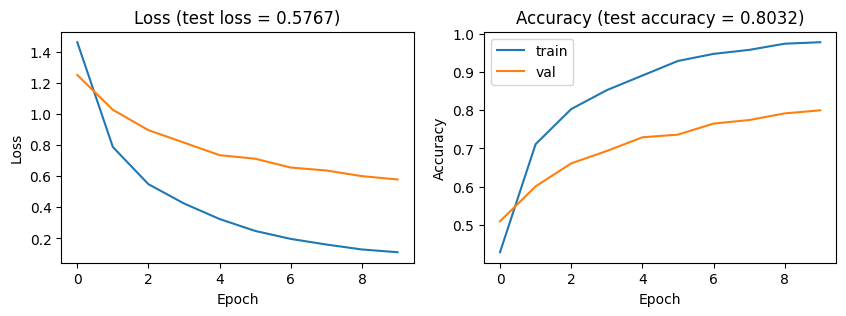

In [ ]:
history = model_ft2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_ft2.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

## Step 3c - finetuning of the last 2 layers (after last block) with same classifier

In [ ]:
model_ft3 = create_finetuning_model(152)

27/27 - 0s - loss: 0.5122 - accuracy: 0.8241 - 454ms/epoch - 17ms/step


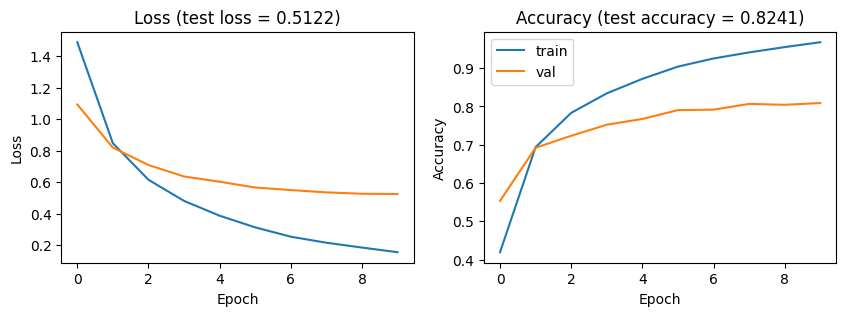

In [ ]:
history = model_ft3.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_ft3.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

## Step 3d - finetuning of last 11 blocks with same classifier

In [ ]:
model_ft4 = create_finetuning_model(55)

27/27 - 0s - loss: 0.4673 - accuracy: 0.8380 - 406ms/epoch - 15ms/step


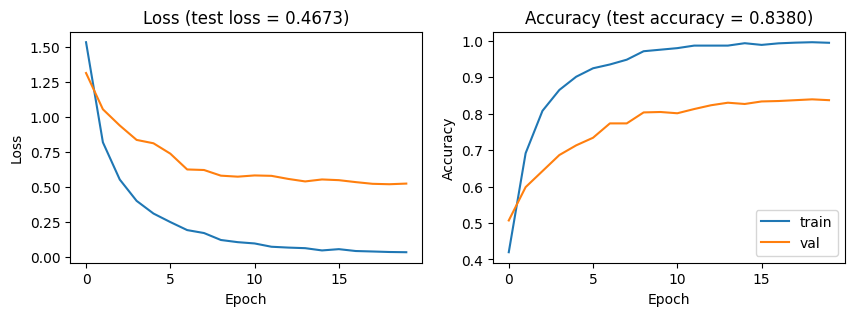

In [ ]:
history = model_ft4.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_ft4.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

Fine tuning does not seem to improve model performace. Takes longer to reach convergence

# Hyperparameter tuning

Based on results above seems that fine-tuning does not improve model performance. Only training a new classifier gives best result and converges the fastest. Hyperparameter tuning will therefore be focused on feature extraction testing the following hyperparameters:
* number of neurons
* number of layers
* drop-out layer with/without
* drop-out rate
* reguliser 'l2' or none

## Define function for creating model with different classification heads

In [ ]:
def flexible_feature_extraction_model(num_dense_layers, num_neurons, use_drop_out: bool, drop_out_rate, kernel_regularizer):
    # read in MobileNetV2 model without the dense classification layers and freeze
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False

    # add classification layer
    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(num_neurons, activation='relu', kernel_regularizer = kernel_regularizer)(x)
    for _ in range(num_dense_layers-1):
      x = Dense(num_neurons, activation='relu', kernel_regularizer = kernel_regularizer)(x)
    if use_drop_out is True:
      x = Dropout(drop_out_rate)(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

## Find best parameters with KerasClassifier and RandomizedSearchCV

In [ ]:
model_to_search = KerasClassifier(
  model=flexible_feature_extraction_model,
  batch_size=-1,
  verbose=0,
  epochs=10,
  validation_split = 0.25,  #can not use validation_data=(X_val, y_val),
  validation_batch_size=-1,
  num_neurons = 64,
  num_dense_layers = 1,
  use_drop_out = False,
  drop_out_rate = 0.2,
  kernel_regularizer = None
)

param_dist = {
  'num_neurons': [64, 512],
  'num_dense_layers': [1, 2],
  'use_drop_out': [False, True],
  'drop_out_rate': [0.2, 0.5],
  'kernel_regularizer': [None, 'l2']
}

random_grid = RandomizedSearchCV(estimator=model_to_search, param_distributions=param_dist, cv=3, n_iter=10) # will search 10 combinations

# Run grid search
estimator = random_grid.fit(X_trainval, y_trainval) # since can not define train and val data explicitely, thus using trainval with validation_split = 0.25
best_params = estimator.best_params_
print(f'Best parameters are: {best_params}')

9406464/9406464 [==============================] - 1s 0us/step


Best parameters are: {'use_drop_out': False, 'num_neurons': 512, 'num_dense_layers': 1, 'kernel_regularizer': 'l2', 'drop_out_rate': 0.2}


## Train and visualize the model with best parameters according to RandomizedSearchCV
The best model seems to be same as model_fe1 but with l2 regulizer and 512 neurons instead of 64 in the dense layer.

In [ ]:
best_model = flexible_feature_extraction_model(**estimator.best_params_)

Epoch 1/10
81/81 [==============================] - 9s 48ms/step - loss: 7.7283 - accuracy: 0.7451 - val_loss: 4.0398 - val_accuracy: 0.8021
Epoch 2/10
81/81 [==============================] - 3s 32ms/step - loss: 2.4007 - accuracy: 0.9343 - val_loss: 1.9044 - val_accuracy: 0.8426
Epoch 3/10
81/81 [==============================] - 2s 31ms/step - loss: 1.0976 - accuracy: 0.9726 - val_loss: 1.2945 - val_accuracy: 0.8137
Epoch 4/10
81/81 [==============================] - 2s 26ms/step - loss: 0.7279 - accuracy: 0.9621 - val_loss: 1.0922 - val_accuracy: 0.8356
Epoch 5/10
81/81 [==============================] - 2s 26ms/step - loss: 0.7093 - accuracy: 0.9486 - val_loss: 1.2025 - val_accuracy: 0.8148
Epoch 6/10
81/81 [==============================] - 2s 29ms/step - loss: 0.6028 - accuracy: 0.9548 - val_loss: 0.9321 - val_accuracy: 0.8345
Epoch 7/10
81/81 [==============================] - 2s 29ms/step - loss: 0.5319 - accuracy: 0.9548 - val_loss: 0.9977 - val_accuracy: 0.8275
Epoch 8/10
81

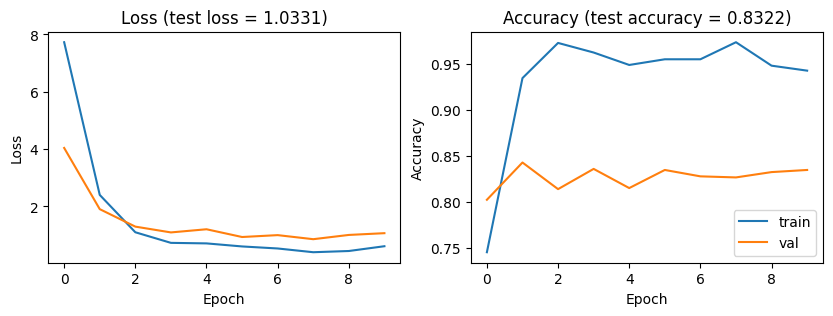

In [ ]:
history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

27/27 [==============================] - 2s 18ms/step


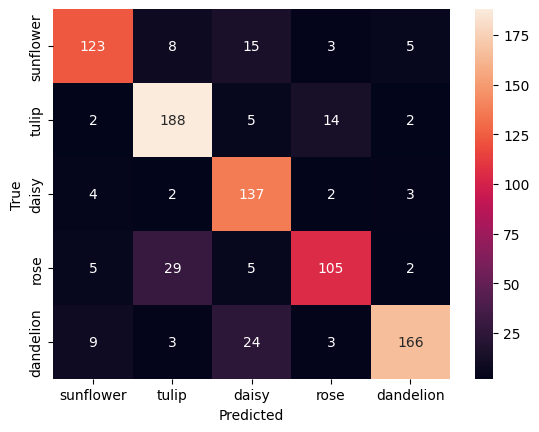

In [ ]:
y_pred = best_model.predict(X_test)
display_confusion_matrix(y_pred, y_test, labels_list)

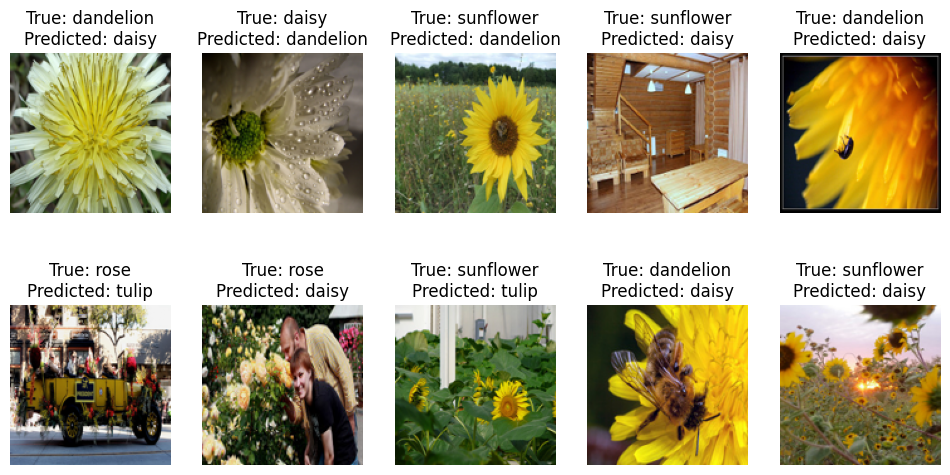

In [ ]:
display_missclassified(y_test, y_pred, labels_list)

RandomSearchCV suggested model parameters ('best_model') does not outperform 'model_fe1'. This parameter combination might thus have been missed which is a risk with the random function. Full search with GridSearchCV can be done to test all combinations.\
Furthermore, all model outcomes are fairly similar. Accuracy could probably be furhter impoved with cleaning out obvouls outliers from the dataset.